In [66]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [67]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [68]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [69]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [70]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [71]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [72]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [73]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [74]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')

for y in columns:
    print(y['name'], y['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [75]:
inspector = inspect(engine)
columns = inspector.get_columns('station')

for y in columns:
    print(y['name'], y['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [76]:
# Find the most recent date in the data set.
# func.max
import datetime as dt
Maxdate = session.query(func.max(measurement.date)).scalar()
print(Maxdate)

2017-08-23


In [77]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# use Datetime
lastprcp = session.query(measurement.prcp)\
    .filter(measurement.date == Maxdate).all()

# Calculate the date one year from the last date in data set.
yearago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
fullyear = session.query(measurement.prcp, measurement.date)\
    .filter(measurement.date <= Maxdate)\
    .filter(measurement.date >= yearago).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
Date = []
prcp = []

for x in fullyear:
    Date.append(x.date)
    prcp.append(x.prcp)

In [78]:
# Sort the dataframe by date
prcpDF = pd.DataFrame({
    'Date': Date,
    'PRCP Value': prcp
})
DF = prcpDF.sort_values(["Date"], ascending=True)
DF = DF.dropna(how="any")
DF.set_index(["Date"], inplace=True)
DF

,PRCP Value
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


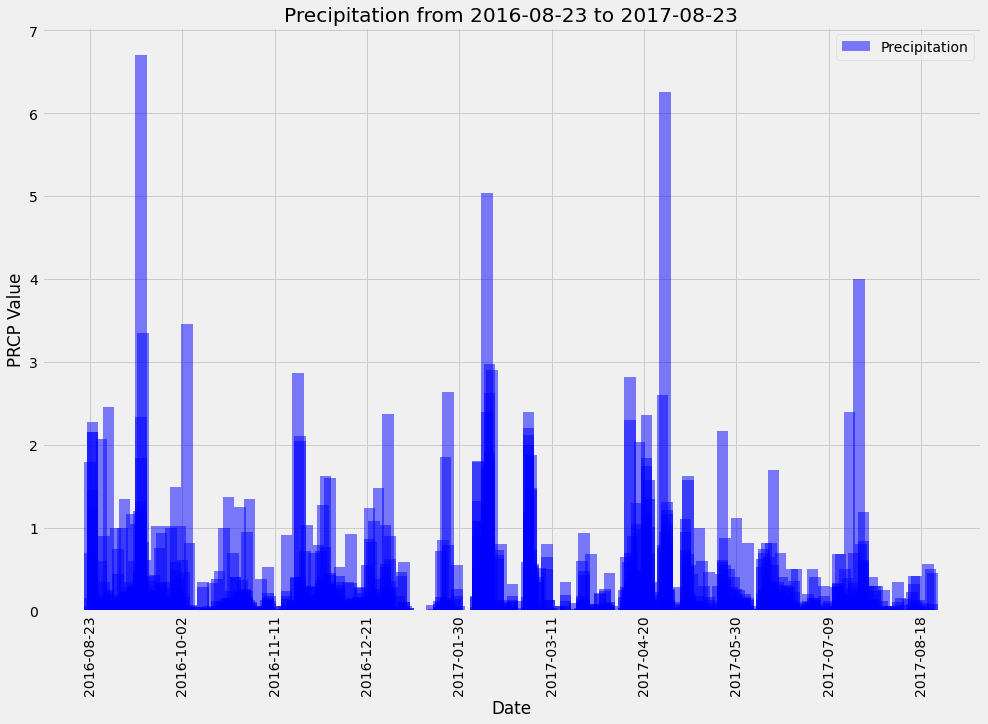

In [79]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(15,10))
plt.bar(DF.index, DF['PRCP Value'],width = 5 ,color='b', alpha=0.5, align="center",label='Precipitation')
plt.tick_params(axis='x',which='both') 
major_ticks = np.arange(0,400,40)
plt.xticks(major_ticks, rotation = 90)

plt.title(f"Precipitation from {yearago} to {Maxdate}")
plt.xlabel("Date")
plt.ylabel("PRCP Value")
plt.grid(True)
plt.legend()
plt.show()

In [80]:
# Use Pandas to calcualte the summary statistics for the precipitation data
DF.describe()

,PRCP Value
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [81]:
# Design a query to calculate the total number stations in the dataset
# func.count (should be under 10)
totalstations = session.query(func.count(station.station)).scalar()
print(totalstations)

9


In [82]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active = session.query(measurement.station, func.count(measurement.id))\
    .group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [83]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
AvgUSC81 = session.query(func.avg(measurement.tobs)).filter(measurement.station == "USC00519281")\
    .filter(measurement.date <= Maxdate)\
    .filter(measurement.date >= yearago).all()

MaxUSC81 = session.query(func.max(measurement.tobs)).filter(measurement.station == "USC00519281")\
    .filter(measurement.date <= Maxdate)\
    .filter(measurement.date >= yearago).all()

MinUSC81 = session.query(func.min(measurement.tobs)).filter(measurement.station == "USC00519281")\
    .filter(measurement.date <= Maxdate)\
    .filter(measurement.date >= yearago).all()

print(f"USC00519281 Average temperature: {AvgUSC81}")
print(f"USC00519281 Max temperature: {MaxUSC81}")
print(f"USC00519281 Min temperature: {MinUSC81}")


USC00519281 Average temperature: [(73.10795454545455,)]
USC00519281 Max temperature: [(83.0,)]
USC00519281 Min temperature: [(59.0,)]


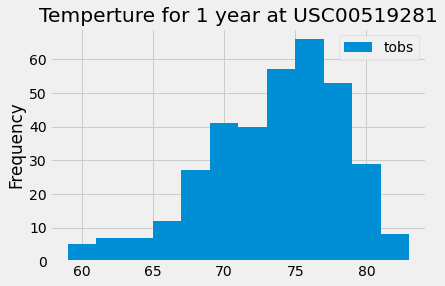

In [84]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC81 = session.query(measurement.tobs).filter(measurement.station == "USC00519281")\
    .filter(measurement.date <= Maxdate)\
    .filter(measurement.date >= yearago).all()

temp = []

for y in USC81:
    temp.append(y.tobs)


plt.hist(temp, bins=12, label="tobs")
plt.ylabel("Frequency")
plt.title("Temperture for 1 year at USC00519281")
plt.legend()

# Close session

In [85]:
# Close Session
session.close()